In [1]:
run_cycle = 1

In [2]:
# Parameters
run_cycle = 13


[55.55555556 55.55555556 55.55555556 55.55555556 55.55555556 55.55555556
 55.55555556 55.55555556 55.55555556 55.55555556 55.55555556 55.55555556
 55.55555556 55.55555556 55.55555556 55.55555556 55.55555556 55.55555556]
r0 6
r1 17
r2 17
r3 3
r4 13
r5 12
r6 6
r7 17
r8 17
r9 9
m0 9
m1 17
m2 3
m3 1
m4 5
m5 6
m6 5
m7 9
m8 18


execution time 3191.16 sec
r0
r9


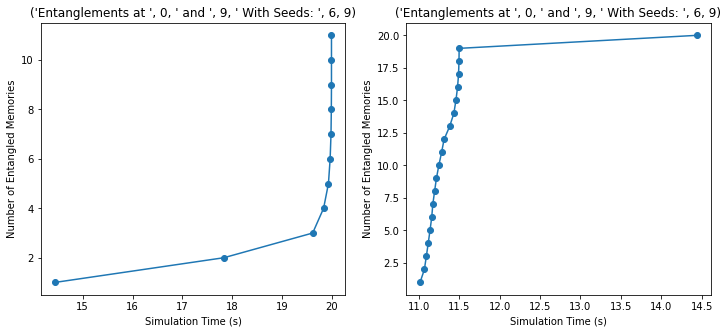

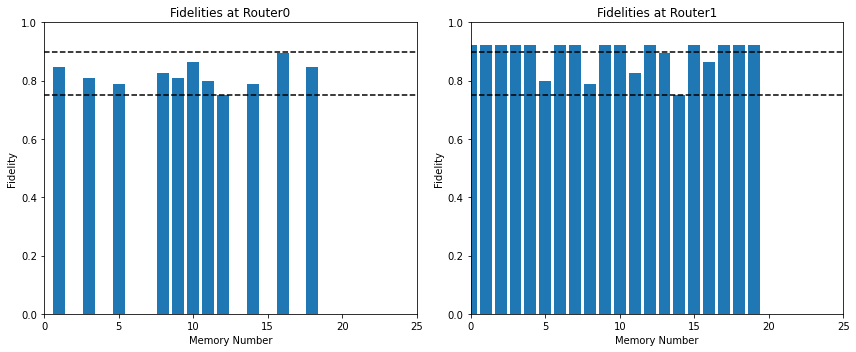

In [3]:
import random
import datetime
from ipywidgets import interact
from matplotlib import pyplot as plt
import time
import os
#print("THIS IS THE PATH",os.getcwd(), "END OF PATH")
import sys
#print(sys.path, "END OF SYS PATH")

from sequence.kernel.timeline import Timeline
from sequence.topology.node import QuantumRouter, BSMNode
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel

import numpy as np

def odd_numbers(start, end):
    return [i for i in range(start, end + 1) if i % 2 != 0]


now = datetime.datetime.now()
date_time_str =now.strftime('%Y%m%d_%H%M%S')


def test(sim_time, cc_delay, qc_atten, qc_dist, num_nodes, starting_node, desired_node):
    """
    sim_time: duration of simulation time (ms)
    cc_delay: delay on classical channels (ms)
    qc_atten: attenuation on quantum channels (dB/m)
    qc_dist: distance of quantum channels (km) 
    num_nodes: number of router nodes you want the system to have
    """
    
    PS_PER_MS = 1e9
    M_PER_KM = 1e3
    
    qc_dist = qc_dist.astype(float)
    # convert units for cc delay (to ps) and qc distance (to m)
    cc_delay *= PS_PER_MS
    qc_dist *= M_PER_KM
    
    raw_fidelity = 0.75
    
    # construct the simulation timeline; the constructor argument is the simulation time (in ps)
    tl = Timeline(sim_time * PS_PER_MS)
    
    # DO THIS IN A LOOP, HOW DO THE MEMORIES WORK THOUGH?, 
    # MAKE ROUTERS AN ARRAY AND PASS IN ANOTHER PARAMETER WHICH SPECIFIES NUMBER OF NODES
    routers = [QuantumRouter] * num_nodes
    ## create our quantum network and update parameters as needed
    for i in range(0, num_nodes):
        routers[i] = QuantumRouter("r" + str(i), tl, 100)
        
    BSMNodes = [BSMNode] * (num_nodes - 1)
    for i in range(0, num_nodes - 1):
        BSMNodes[i] = BSMNode("m" + str(i), tl, [routers[i].name, routers[i+1].name])    

    #USE LOOP TO MAKE CONNECTIONS BETWEEN BSM NODES AND ROUTERS
    for i in range(0,num_nodes - 1):
        routers[i].add_bsm_node(BSMNodes[i].name, routers[i + 1].name)
        routers[i + 1].add_bsm_node(BSMNodes[i].name, routers[i].name)
        #adds a 2-way connection between adjacent nodes
    #routers[0].add_bsm_node(BSMNodes[0].name, routers[1].name)
    #routers[1].add_bsm_node(BSMNodes[0].name, routers[0].name)
    #routers[1].add_bsm_node(BSMNodes[1].name, routers[2].name)
    #routers[2].add_bsm_node(BSMNodes[1].name, routers[1].name)
    #routers[2].add_bsm_node(BSMNodes[2].name, routers[3].name)
    #routers[3].add_bsm_node(BSMNodes[2].name, routers[2].name)
    """
    r0.add_bsm_node(m0.name, r1.name)
    r1.add_bsm_node(m0.name, r0.name)
    r1.add_bsm_node(m1.name, r2.name)
    r2.add_bsm_node(m1.name, r1.name)
    """
    
    # set seeds for random generators
    nodes = []
    nodes_seeds = []
    for router in routers:
        nodes.append(router)
    for bsm_node in BSMNodes:
        nodes.append(bsm_node)
    for i, node in enumerate(nodes):
        seed_random = random.randint(1, len(nodes))
        node.set_seed(seed_random)
        nodes_seeds.append(seed_random)
        print(node.name,seed_random)
    
    for node in routers:
        memory_array = node.get_components_by_type("MemoryArray")[0]
        # we update the coherence time (measured in seconds) here
        memory_array.update_memory_params("coherence_time", 10)
        # and similarly update the fidelity of entanglement for the memories
        memory_array.update_memory_params("raw_fidelity", raw_fidelity)
    
    # create all-to-all classical connections
    for node1 in nodes:
        for node2 in nodes:
            if node1 == node2:
                continue
            # construct a classical communication channel
            # (with arguments for the channel name, timeline, length (in m), and delay (in ps))
            cc = ClassicalChannel("cc_%s_%s"%(node1.name, node2.name), tl, 1e3, delay=cc_delay)
            cc.set_ends(node1, node2.name)
            
    # NOTE: CLASSICAL CHANNEL DELAY CAN NOT CURRENTLY BE DIFFERENT FOR EACH CLASSICAL CHANNEL

    
    # DO THIS IN A LOOP, TAKE IN qc_dist, qc_atten as arrays 
            
    # create quantum channels linking r1 and r2 to m1
    # (with arguments for the channel name, timeline, attenuation (in dB/km), and distance (in m))
    qc_array = [None] * (num_nodes - 1) * 2
    j = 0
    for i in range(0, len(qc_array), 2):
        qc_array[i] = QuantumChannel("qc_r" + str(j) + "_m" + str(j), tl, qc_atten, qc_dist[i])
        qc_array[i + 1] = QuantumChannel("qc_r" + str(j + 1) + "_m" + str(j), tl, qc_atten, qc_dist[i + 1])
        qc_array[i].set_ends(routers[j], BSMNodes[j].name)
        qc_array[i + 1].set_ends(routers[j + 1], BSMNodes[j].name)
        j += 1

    """
    qc_array = [QuantumChannel] * (num_nodes - 1) * 2
    j = 0
    for i in odd_numbers(0,((num_nodes - 1) * 2)):
        qc_array[i-1] = QuantumChannel("qc_r" + str(j) + "_m" + str(j), tl, qc_atten, qc_dist[i-1])
        qc_array[i] = QuantumChannel("qc_r" + str(j+1) + "_m" + str(j), tl, qc_atten, qc_dist[i])
        qc_array[i-1].set_ends(routers[j], BSMNodes[j].name)
        qc_array[i].set_ends(routers[j+1], BSMNodes[j].name)
        
        j+=1
        
    """
    """
    qc0 = QuantumChannel("qc_r1_m1", tl, qc_atten, qc_dist)
    qc1 = QuantumChannel("qc_r2_m1", tl, qc_atten, qc_dist)
    qc0.set_ends(routers[0], BSMNodes[0].name)
    qc1.set_ends(routers[1], BSMNodes[0].name)
    # create quantum channels linking r2 and r3 to m2
    qc2 = QuantumChannel("qc_r2_m2", tl, qc_atten, qc_dist)
    qc3 = QuantumChannel("qc_r3_m2", tl, qc_atten, qc_dist)
    qc2.set_ends(routers[1], BSMNodes[1].name)
    qc3.set_ends(routers[2], BSMNodes[1].name)
    # create quantum channels linking r3 and r4 to m3
    qc4 = QuantumChannel("qc_r3_m3", tl, qc_atten, qc_dist)
    qc5 = QuantumChannel("qc_r4_m3", tl, qc_atten, qc_dist)
    qc4.set_ends(routers[2], BSMNodes[2].name)
    qc5.set_ends(routers[3], BSMNodes[2].name)
    """

    # create routing table manually <- WILL USE RL FOR THIS
    # note that the routing table is based on quantum links, not classical
    # the arguments are the names of the destination node and the next node in the best path towards the destination


    
    for i in range(len(routers)):
        for j in range(len(routers)):
            if j != i:
                if i > j:
                    routers[i].network_manager.protocol_stack[0].add_forwarding_rule("r" + str(j), "r" + str(i-1))
                if i < j:
                    routers[i].network_manager.protocol_stack[0].add_forwarding_rule("r" + str(j), "r" + str(i+1))
    
    
    # Setup for Router r0
    """
    
    routers[0].network_manager.protocol_stack[0].add_forwarding_rule("m0", "m0")  # Forward to associated BSM node
    BSMNodes[0].network_manager.protocol_stack[0].add_forwarding_rule("r1", "r1")  # Forward to associated router
    # Setup for Router r1
    routers[1].network_manager.protocol_stack[0].add_forwarding_rule("m0", "m0")  # Forward to BSM node associated with previous router
    routers[1].network_manager.protocol_stack[0].add_forwarding_rule("m1", "m1")  # Forward to associated BSM node

    # Setup for Router r2
    routers[2].network_manager.protocol_stack[0].add_forwarding_rule("m1", "m1")  # Forward to BSM node associated with previous router
    routers[2].network_manager.protocol_stack[0].add_forwarding_rule("m2", "m2")  # Forward to associated BSM node

    # Setup for Router r3
    routers[3].network_manager.protocol_stack[0].add_forwarding_rule("m2", "m2")  # Forward to BSM node associated with previous router
    routers[3].network_manager.protocol_stack[0].add_forwarding_rule("m3", "m3")  # Forward to associated BSM node

    # Setup for Router r4
    routers[4].network_manager.protocol_stack[0].add_forwarding_rule("m3", "m3")  # Forward to BSM node associated with previous router
    
    """
    ## run our simulation
    
    tl.init()
    # we use the network manager of an end router to make our entanglement request
    # here, the arguments are:
    # (1) the destination node name,
    # (2) the start time (in ps) of entanglement,
    # (3) the end time (in ps) of entanglement,
    # (4) the number of memories to entangle, and
    # (5) the desired fidelity of entanglement.
    routers[starting_node].network_manager.request("r" + str(desired_node), 1e12, 1e14, 20, 0.9)

    tick = time.time()
    tl.run()
    print("execution time %.2f sec" % (time.time() - tick))
    
    ## display metrics for entangled memories
    routers_to_plot = [routers[starting_node],routers[desired_node]]
    fig, axs = plt.subplots(1, len(routers_to_plot))
    fig.set_size_inches(12, 5)

    # entangled memories on r1
    # here, we plot the number of entangled memories versus time for r1
    for i in range(0,len(routers_to_plot)):
        data = []
        for info in routers_to_plot[i].resource_manager.memory_manager:
            if info.entangle_time > 0:
                data.append(info.entangle_time / 1e12)
        data.sort()
        axs[i].plot(data, range(1, len(data) + 1), marker="o")
        str_title = "Entanglements at ",starting_node, " and " ,desired_node, " With Seeds: ", nodes_seeds[starting_node], nodes_seeds[desired_node]
        axs[i].set_title(str_title)
        axs[i].set_ylabel("Number of Entangled Memories")
        axs[i].set_xlabel("Simulation Time (s)")
        
        plt.figure()  # Create a new figure to prevent overlap
        plt.plot(data, range(1, len(data) + 1), marker="o")
        plt.title(str_title)
        plt.ylabel("Number of Entangled Memories")
        plt.xlabel("Simulation Time (s)")
        plt.savefig(f"/home/uom/howe0427/SeQUeNCe/plots/entanglements_1000km_{desired_node + 1}_{i}_{run_cycle}_{date_time_str}.png")  # Save the current figure
        plt.close()  # Close the figure to free memory

    ## display metrics for memory fidelities
    
    fig, axs = plt.subplots(1, len(routers_to_plot))
    fig.set_size_inches(12, 5)
    
    # display collected metric for memory fidelities on r1
    # in this case, a bar chart of memory fidelity at each index
    for i in range(0,len(routers_to_plot)):
        data = []
        for info in routers_to_plot[i].resource_manager.memory_manager:
            data.append(info.fidelity)
        axs[i].bar(range(len(data)), data)
        axs[i].plot([0, len(data)], [raw_fidelity, raw_fidelity], "k--")
        axs[i].plot([0, len(data)], [0.9, 0.9], "k--")
        axs[i].set_ylim(0,1)
        axs[i].set_xlim(0,25)
        print(routers_to_plot[i].name)
        axs[i].set_title("Fidelities at Router" + str(i))
        axs[i].set_ylabel("Fidelity")
        axs[i].set_xlabel("Memory Number")
    
    fig.tight_layout()
    
#interactive_plot = interact(test, sim_time=(2000, 4000, 500), cc_delay=(0.1, 1, 0.1), qc_atten=[1e-5, 2e-5, 3e-5], qc_dist=(1, 10, 1))
#interactive_plot
num_nodes = 10
size = 2*(num_nodes - 1)
#qc_distances = np.random.randint(1, 9, size)
tot_distance = 1000
qc_distances = np.ones(size) * (tot_distance / size)
#qc_distances = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
print(qc_distances)
starting = 0
desired = 9
test(20000, 0.1, 1e-5, qc_distances, num_nodes, starting, desired)

### Results

We note that the number of entangled memories increses exponentially over time. This is due to memory expiration, with a coherence time of 0.3 seconds, as well as the consumption of memories for purification and swapping soon after they are entangled. We also see distinct layers of fidelities, reflecting the number of times an individual memory has been purified or swapped.